# Customer Segmentation using K-Means Clustering
### This notebook demonstrates customer segmentation using clustering techniques. The steps include data preprocessing, feature engineering, clustering, and visualization.

## Import Necessary Libraries
        

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")

C:\Users\Sean Xander Aquino\AppData\Local\Temp\ipykernel_2676\2550566528.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load and Process the Dataset

In [2]:
dataset = fetch_ucirepo(id=352)
df = dataset.data.original.copy()

### Data Cleaning


In [3]:
df = df.dropna(subset=["CustomerID"])               # this will remove the rows with missing customer IDs
df = df[df["Quantity"] > 0]                          # to only keep the valid purchase quantities
df = df[df["UnitPrice"] > 0]                         # remove free or negative-priced entries
df = df[df["Country"] == "United Kingdom"] 

### Aggregating the data for analysis

In [4]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

customer_df = df.groupby("CustomerID").agg({
    "Quantity": "sum",              # Total items bought
    "TotalPrice": "sum",            # Total money spent
    "Description": "nunique",       # Unique item types bought
    "InvoiceDate": "nunique"        # Purchase frequency (by invoice dates)
}).rename(columns={
    "Quantity": "TotalQuantity",
    "TotalPrice": "TotalSpent",
    "Description": "ProductVariety",
    "InvoiceDate": "PurchaseFrequency"
}).reset_index()

### Standardizing the features

In [5]:
features = ["TotalQuantity", "TotalSpent", "ProductVariety", "PurchaseFrequency"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])

### Determining the optimal number of clusters

### Elbow Method - helps identify the optimal number of clusters by plotting the inertia (sum of squared distances) for different values of `k`.

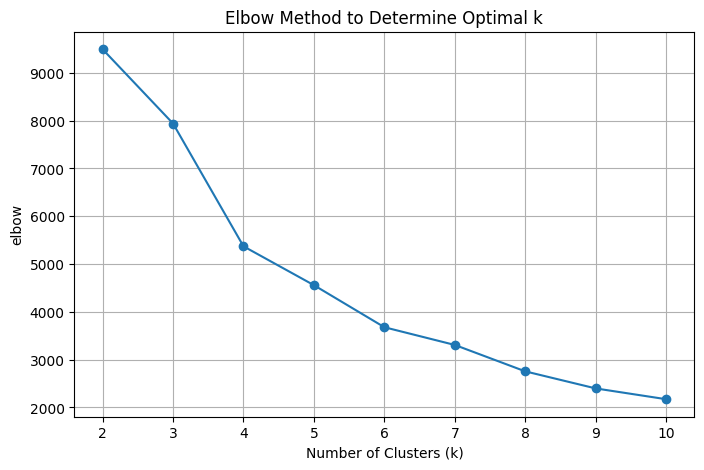

In [6]:
elbow = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    elbow.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, elbow, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('elbow')
plt.grid(True)
plt.show()

### Silhouette Score - measures the quality of clustering by evaluating how similar each point is to its own cluster compared to other clusters.


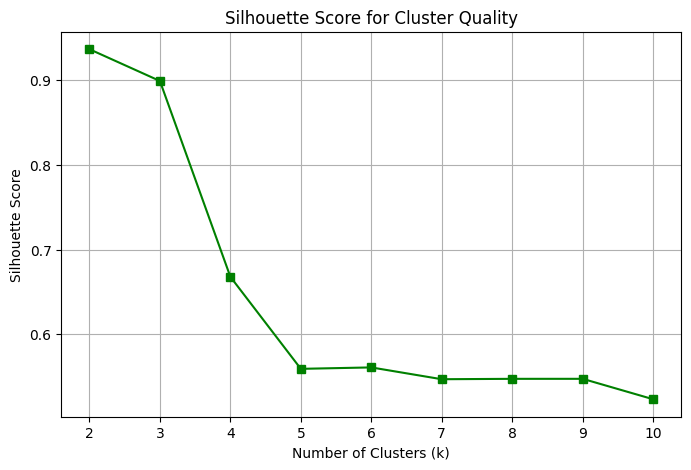

In [7]:
sil_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, marker='s', color='green')
plt.title('Silhouette Score for Cluster Quality')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Perform clustering

In [8]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

### Labelling the clusters

In [9]:
cluster_summary = customer_df.groupby("Cluster")[features].mean().sort_values("TotalSpent", ascending=False)
cluster_ranks = cluster_summary.reset_index().copy()
cluster_ranks["ClusterLabel"] = ["High-Value", "Moderate", "Low-Value"][:optimal_k]

In [10]:
# Assigning labels to clusters based on their ranks
label_map = dict(zip(cluster_ranks["Cluster"], cluster_ranks["ClusterLabel"]))
customer_df["ClusterLabel"] = customer_df["Cluster"].map(label_map)

### Visualization of the clusters

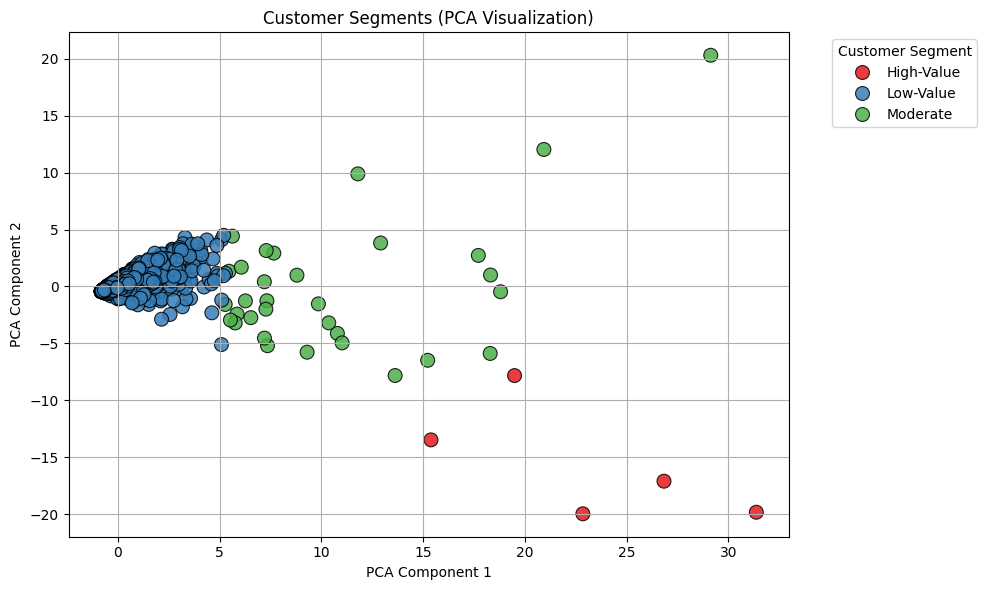

In [11]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatterplot with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=customer_df["ClusterLabel"],
    palette="Set1",
    s=100,
    alpha=0.85,
    edgecolor="k"
)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Customer Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Summary for interpretation

In [13]:
print("Cluster Summary:\n")
print(customer_df.groupby("ClusterLabel")[features].mean().round(2))

Cluster Summary:

              TotalQuantity  TotalSpent  ProductVariety  PurchaseFrequency
ClusterLabel                                                              
High-Value         70775.60   158185.31          151.20              27.20
Low-Value            804.23     1364.81           58.60               3.82
Moderate           24375.69    38060.00          345.78              50.22
